# 一、玻尔兹曼机
玻尔兹曼机是一个随机动力系统，每个变量的状态都以一定的概率受到其他变量的影响。  
玻尔兹曼机可以用概率无向图模型来描述，一个具有K个结点的玻尔兹曼机满足以下三个性质：  
* 1、每个随机变量都是二值的所有随机变量可以用一个二值的随机向量X∈{0，1}^K来表示，其中可观测变量表示为V，隐变量表示为H。
* 2、所有节点之间是全连接的，每个变量Xi都依赖于所有其他变量X\i。
* 3、每两个变量之间相互影响（Xi->Xj和Xj->Xi）是对称的，即权重对称。

# 二、受限玻尔兹曼机
## 2.1、初始化并下载mnist手写数字数据集

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

## 2.2、初始化RBM
一个RBM有两个层，第一层叫可视层(visible)或者输入层，第二层是隐藏层( hidden layer)。  
初始化RBM中的参数，包括可视层和隐含层的偏置、可视层和隐含层的权重、最初可视层的输入。  
MNIST数据集为28X28像素的图片，因此可视层输入为784.  
隐含层设为i个神经元，每个神经元都是二值的。  
此处i取500.

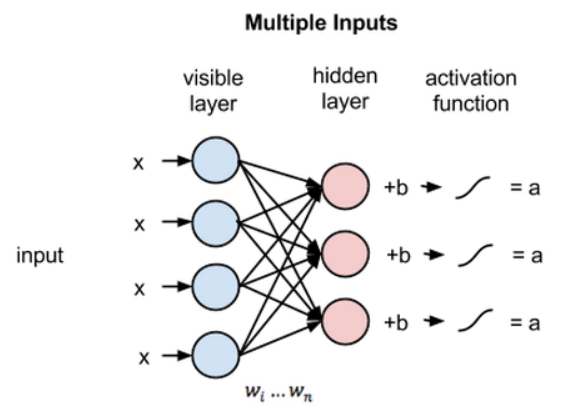

第一层的每一个节点有一个偏置，使用vb表示；  
第二层的每一个节点也有一个偏置，使用hb表示；

In [4]:
import tensorflow as tf

In [5]:
# 初始化
# 可视层到隐含层的偏差
vb = tf.placeholder("float", [784])
# 隐含层到可视层的偏差（i取500）
hb = tf.placeholder("float", [500])
# 定义可视层和隐含层之间的权重，行表示输入节点，列表示输出结点，这里的权重矩阵为784X500的矩阵
W = tf.placeholder("float", [784, 500])
# 初始化可视层输入
X = tf.placeholder("float", [None, 784])

## 2.3、正向传播
输入的数据经过可视层的所有节点传递到隐含层，采用sigmoid作为激活函数

In [6]:
# 正向传播
# _h0=sigmoid(X⊗W+hb) 隐含层的概率输出
_h0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
# h0=sampleProb(_h0) 隐含层的采样输出 吉布斯采样方法
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

## 2.4、反向传播
反向(重构)： RBM在可视层和隐含层之间通过对比散度算法多次前向后向传播重构数据。  
所以在这个阶段，从隐含层(h0)采样得到的激活向量作为输入。相同的权重矩阵和可视层偏差将用于计算并通sigmoid函数。其输出是一个重构的结果，它近似原始输入。

In [7]:
# 反向传播
# 可视层的概率输出
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
# 可视层的采样输出
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
# 第二轮隐含层的概率输出
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

## 2.5、对比散度（CD-k）算法
对比散度实际是一个用来计算和调整权重矩阵的一个矩阵。 改变权重W渐渐地变成了权重值的训练。然后在每一步(epoch)， W会根据学习率进行更新。

In [8]:
# 定义学习率
alpha = 1.0
# 正梯度X和h0的外积 transpose()转置函数
w_pos_grad = tf.matmul(tf.transpose(X), h0)
# 负梯度v1和h1的外积
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
# 对比散度 = 正梯度 - 负梯度， 对比散度矩阵为784X500大小的矩阵
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X)[0])
# 更新权重为W' = W + alpha * CD
update_w = W + alpha * CD
# 更新偏置
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

## 2.6、定义目标函数
目的是最大限度地提高我们从该分布中获取数据的可能性。  
目标函数计算从第1步到第n步的平方误差的和，这显示了数据和重构数据的误差，误差越小表明训练效果越好。

In [9]:
err = tf.reduce_mean(tf.square(X - v1))

## 2.7、训练过程
指定一个误差下限，等到误差足够小，小到低于这个下限，就退出训练。  
根据训练结果，指定的下限是0.045。

In [10]:
print("W:", W.shape)
print("vb:", vb.shape)
print("hb:", hb.shape)

W: (784, 500)
vb: (784,)
hb: (500,)


In [11]:
import numpy as np

prv_w = np.zeros([784, 500], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([500], np.float32)

cur_w = np.zeros([784, 500], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([500], np.float32)

In [12]:
# 定义超级参数
epochs = 5
batchsize = 100
weights = []
errors = []

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
sess.run(err, feed_dict={X: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.4811536

In [14]:
for epoch in range(epochs):
    for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={
                         X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={
                          X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={
                          X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(
                sess.run(err, feed_dict={X: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print('Epoch: %d' % epoch, 'reconstruction error: %f' % errors[-1])

Epoch: 0 reconstruction error: 0.062752
Epoch: 1 reconstruction error: 0.054647
Epoch: 2 reconstruction error: 0.050481
Epoch: 3 reconstruction error: 0.048434
Epoch: 4 reconstruction error: 0.046928


In [15]:
import matplotlib.pyplot as plt

plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

<Figure size 640x480 with 1 Axes>

In [16]:
uw = weights[-1].T
print(uw)

[[-0.2451532  -0.2600322  -0.24011558 ... -0.21007545 -0.26005638
  -0.23005806]
 [-0.24510711 -0.26050943 -0.24011067 ... -0.21136545 -0.26042807
  -0.23718138]
 [-0.24503997 -0.2600012  -0.24002163 ... -0.21000779 -0.26000527
  -0.2300178 ]
 ...
 [-0.29035357 -0.28785074 -0.25770792 ... -0.22183695 -0.26745862
  -0.25947812]
 [-0.24510236 -0.2600109  -0.24007288 ... -0.21003047 -0.26005116
  -0.23003322]
 [-0.24504012 -0.26000258 -0.24003649 ... -0.21001525 -0.26001087
  -0.23000978]]


## 2.8、测试
训练过后，我们能够获得每一个隐藏的单元并可视化隐含层和输入层之间的连接。我们可以通过重构得到一张图片。

In [17]:
def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    """
    Transform an array with one flattened image per row into an array in
    which images are reshaped and layed out like tiles on a floor.
    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).
    :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
    be 2-D ndarrays or None;
    :param X: a 2-D array in which every row is a flattened image.
    :type img_shape: tuple; (height, width)
    :param img_shape: the original shape of each image
    :type tile_shape: tuple; (rows, cols)
    :param tile_shape: the number of images to tile (rows, cols)，
     在每行每列上分别有多少个图像
    :param output_pixel_vals: if output should be pixel values (i.e. int8
    values) or floats 是否以图像的形式进行显示
    :param scale_rows_to_unit_interval: if the values need to be scaled before
    being plotted to [0,1] or not
    :returns: array suitable for viewing as an image.
    (See:`Image.fromarray`.)
    :rtype: a 2-d array with same dtype as X.
    """
    # 对参数进行断言，确保它们都是二维元组
    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [
        (ishp + tsp) * tshp - tsp
        for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)
    ]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output np ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4),
                                    dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4),
                                    dtype=X.dtype)

        # colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                dt = out_array.dtype
                if output_pixel_vals:
                    dt = 'uint8'
                out_array[:, :, i] = np.zeros(
                    out_shape,
                    dtype=dt
                ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(
                    X[i], img_shape, tile_shape, tile_spacing,
                    scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        dt = X.dtype
        if output_pixel_vals:
            dt = 'uint8'
        out_array = np.zeros(out_shape, dtype=dt)

        # begin to tile the images
        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                # a 2-D array in which every row is a flattened image
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(
                            this_x.reshape(img_shape))
                    else:
                        this_img = this_x.reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    c = 1
                    if output_pixel_vals:
                        c = 255
                    out_array[
                        tile_row * (H + Hs): tile_row * (H + Hs) + H,
                        tile_col * (W + Ws): tile_col * (W + Ws) + W
                    ] = this_img * c
        return out_array

In [18]:
def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar

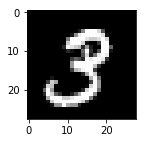

In [19]:
from PIL import Image

sample_case = trX[1:2]
img = Image.fromarray(tile_raster_images(X=sample_case, img_shape=(
    28, 28), tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')

In [20]:
hh0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={X: sample_case, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

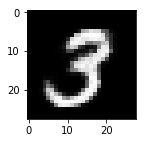

In [21]:
img = Image.fromarray(tile_raster_images(X=rec, img_shape=(
    28, 28), tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')

参考文献: [ https://www.cnblogs.com/siucaan/p/9623162.html ]